In [1]:
#setup imports and make ure the files we care about exist
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path
import random
import math
from pprint import pprint

#custom modules
import feature_extraction
import unsw_nb15_dataset
import networks

from importlib import reload #allow us to reload custom modules any time we like with modifications
reload(feature_extraction)
reload(unsw_nb15_dataset)
reload(networks)

<module 'networks' from '/home/jaywalker/MachineLearning/PacketGAN/networks.py'>

Network input data shape:  torch.Size([64, 100, 1])
Number of training examples:  8000


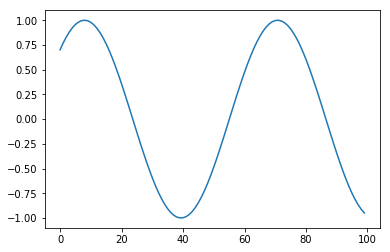

In [2]:
#set up the dataset(s)

#set some hyperparameters
sequence_length=100
batch_size=64 #always using size 1 because I can't seem to make the GRU work correctly with larger batches

class SineDataset:
    #freq defines how many cycles per 100 samples
    def __init__(self, sequence_length = 25, num_examples = 10000, freq = 10):
        self.sine_sequences = torch.zeros(num_examples, sequence_length, 1)
        for batch in range(0, self.sine_sequences.shape[0]):
            phase = random.random() * 6.28;
            for i in range(0, len(self.sine_sequences[batch])):
                self.sine_sequences[batch, i] = math.sin((i/freq) + phase) #fix this to consider frequency
    
    def __getitem__(self, index):
        return self.sine_sequences[index]
        
    def __len__(self):
        return self.sine_sequences.shape[0];


#first, load the dataset
data_set_original = SineDataset(sequence_length = sequence_length)

#get rid of this when you want to use the whole set
fraction_to_use = 1
data_set, _ = random_split(data_set_original, [round(len(data_set_original) * fraction_to_use), len(data_set_original) - round(len(data_set_original) * fraction_to_use)])

train_set_length = round(len(data_set) * 0.8)
test_set_length = len(data_set) - train_set_length
train_set, test_set = random_split(data_set, [train_set_length, test_set_length])

data_loader = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=1)

data_example = None
for count, data in enumerate(data_loader):
    data_example = data
    if count == 0:
        break
        
print("Network input data shape: ", data_example.shape)
print("Number of training examples: ", len(data_loader.dataset))

#visualization of sine wave
plt.plot(range(0, len(data_set_original[0])), data_set_original[0].numpy())
plt.show()

Number of input features:  1
Latent dimensions:  25


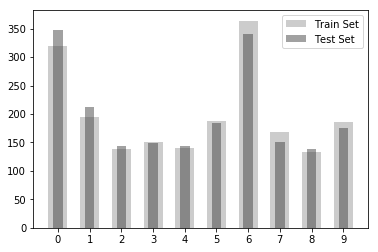

In [3]:
#train a KMeans classifier for cluster evaluation
import evaluation
reload(evaluation)

num_features = data_set[0].shape[1]
print("Number of input features: ", num_features)
latent_dimensions = 25
print("Latent dimensions: ", latent_dimensions)

latent_space_mapper = networks.GRUMapping(num_features, latent_dimensions, batch_size)

#convert the train_set and test_set to a lower dimensional space for clustering
train_set_latent = []
train_comparison_set, _ = random_split(train_set, [len(test_set), len(train_set) - len(test_set)])
train_comparison_set_dl = DataLoader(train_comparison_set, batch_size=batch_size, shuffle=True) #use a dataloader so the examples are batched
with torch.no_grad():
    for example in train_comparison_set_dl:
        if example.shape[0] != batch_size:
            continue #ignore batches that don't fit the network so we don't have to deal with too many technicalities...
            #maybe we could deal with that by changing the size of the hidden state of the network before inputting the data?
        train_set_latent.extend(latent_space_mapper(example).numpy()[0])
        
#print(train_set_latent)

test_set_latent = []
test_set_dl = DataLoader(test_set, batch_size=batch_size, shuffle=True)
with torch.no_grad():
    for example in test_set_dl:
        if example.shape[0] != batch_size:
            continue #ignore batches that don't fit the network to keep things easy
        test_set_latent.extend(latent_space_mapper(example).numpy()[0])

#print("Latent test set length: ", len(test_set_latent))
#pprint(test_set_latent)
#print("Latent test set element size: ", test_set_latent[0].shape)
kmeans = evaluation.KMeansTorch(n_clusters=10)
kmeans.fit(train_set_latent)

#are the train set and test set from the same distribution?
train_counts, test_counts = evaluation.cluster_and_compare(kmeans, train_set_latent, test_set_latent, retrain=False)

In [4]:
#define the networks 
G = networks.Generator(sequence_length, data_example.shape[2], data_example.shape[2] * 200, 50, data_example.shape[2], batch_size, torch.tanh, noise_input=True)
D = networks.Discriminator(sequence_length, data_example.shape[2], data_example.shape[2] * 150, 1, batch_size, torch.sigmoid)

Training: [##############################] 100.0%
Epoch:  10 / 10
D Real Error:  3.0994415283203125e-06
D Fake Error:  3.0994415283203125e-06
G Error:  -0.5003158450126648
Remaining time: 0:00:00


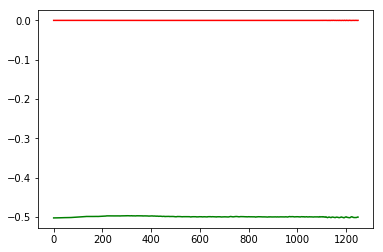

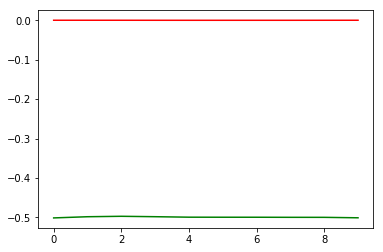

In [5]:
#train GAN to replace masked packets
#by iterating over the dataset for some # of epochs

import train
reload(train)
reload(networks)

#Train the network!
num_epochs = 10
G, D, g_losses, df_losses, g_stats, df_stats = train.train_gan(G,D,data_loader,num_epochs)

#plot instantaneous losses
plt.plot(range(len(df_losses)), df_losses, 'r-', range(len(g_losses)), g_losses, 'g-')
plt.show()

#plot loss averages
plt.plot(range(len(df_stats.get_averages())), df_stats.get_averages(), 'r-', range(len(g_stats.get_averages())), g_stats.get_averages(), 'g-')
plt.show()

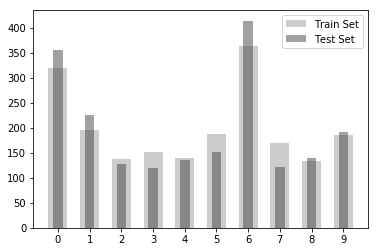

In [6]:
#cluster and compare. Are the fake examples even remotely matching the original distribution?
#first generate a set of masked sequences
gan_latent_test_set = []
with torch.no_grad():
    for example in test_set_dl:
        if example.shape[0] != batch_size:
            continue #ignore batches that don't fit the network to keep things easy
        generated_example = G(example)
        gan_latent_test_set.extend(latent_space_mapper(generated_example).numpy()[0])

#then compare the native GAN output
train_counts, test_counts = evaluation.cluster_and_compare(kmeans, train_set_latent, gan_latent_test_set, retrain=False)

In [16]:
#This is a test of the wasserstein critic/approximate wasserstein distance
import torch.utils.data
import evaluation
reload(evaluation)

real_set, generator_input, _ = random_split(test_set, [len(test_set) // 2, len(test_set) // 2, len(test_set) - (2*(len(test_set) // 2))]) #I'm assuming it's got at least 200 examples to spare
real_set_df = DataLoader(real_set, batch_size=batch_size)
generator_input_df = DataLoader(generator_input, batch_size=batch_size)
print("Len real_set_df: ", len(real_set_df))
print("Len generator_input_df", len(generator_input_df))
real_list = []
#assuming real_train_set and real_test_set are equal length
for e in real_set_df:
    if e.shape[0] != batch_size:
        continue
    real_list.append(e)

fake_list = []
for e in generator_input_df:
    if e.shape[0] != batch_size:
        continue
    with torch.no_grad():
        fake_list.append(G(e)) #G ouput already has batch dimension

print("Real set length: ", len(real_list))
print("Fake set length: ", len(fake_list))
#print(real_list[0].shape)
#print(fake_list[0].shape)

w_hat, accuracy = evaluation.wasserstein_critic(real_list, fake_list, latent_dimensions = 25)
print("Wasserstein Distance: ", w_hat)
print("Classification Accuracy: ", accuracy)


Len real_set_df:  16
Len generator_input_df 16
Real set length:  15
Fake set length:  15


/home/jaywalker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: It is recommended to use a dataset of at least 1000 elements to decrease score variance.


Wasserstein Distance:  0.00022685853764414787
Classification Accuracy:  0.5


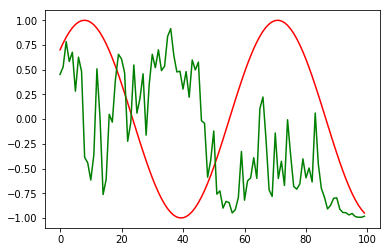

In [12]:
#visualization of real sine wave and generated sine wave
g_sin = fake_list[0][0]

plt.plot(range(0, len(data_set_original[0])), data_set_original[0].numpy(), 'r-', range(0, len(g_sin)), g_sin.numpy(), 'g-')
plt.show()